# Müşteri Segmentasyonu (RFM Metodu)

Merhaba! Bu notebook'ta müşteri segmentasyonu (RFM Metodu) için Lifetimes kütüphanesi ve K-means algoritması kullanarak nasıl segmentasyon yapılacağını göstereceğim.

RFM'ye geçmeden önce, mevcut segmentasyon türlerini göstermek istiyorum:

### Segmentasyon Türleri:

- **Demografik**: Değişkenler: yaş, cinsiyet, medeni durum, meslek.
- **Coğrafi**: Değişkenler: konum, bölge, kırsal/kentsel.
- **Davranışsal**: Değişkenler: harcama, müşteri alışkanlıkları, ürün kullanımı, daha önce satın alınan ürünler.
- **Psikografik**: Değişkenler: sosyal statü, yaşam tarzı, kişisel karakter.

Aslında K-means kullanmak zorunda değiliz, herhangi bir clustering algoritması kullanabilirsiniz. Önemli olan verilerin tamamı sayısal (Recency, Frequency, Monetary Value ve InvoiceDate sayısal verilerdir) ve K-means basit bir algoritma olduğu için K-means kullanıyorum.

K-means'i seçmemin bir diğer nedeni, "her zaman basit modelle başla" prensibi. Neden basit modelle başlamalıyız? Bunun birçok nedeni var, ancak burada detayına girmeyeceğim. Şimdi RFM'ye geçelim.

**RFM**, müşterileri satın alma davranışlarına göre segmentlere ayırmak için kullanılan bir yöntemdir. RFM, **Davranışsal Segmentasyon** türüne aittir. RFM'nin her bir bileşeninin tanımı:

- **Recency (Yenilik)**: Müşterinin en son satın alma işleminden sonraki pasif kalma süresi. *Eğer müşteri sadece bir kez satın alma yaptıysa, recency değeri 0'dır.*

- **Frequency (Sıklık)**: Müşterinin yaptığı *tekrar* satın alma sayısı. Veya toplam satın alma sayısı eksi bir.

- **Monetary Value (Parasal Değer)**: Müşterinin belirli bir zaman diliminde harcadığı ortalama para miktarı. Bu, müşterinin tüm satın almalarının toplamı bölü toplam satın alma sayısına eşittir.

RFM, müşteri tabanını iyi tanımak için kullanılabilir. Örnek olarak, daha önce tüm müşterilere aynı yaklaşımı uyguluyorsanız, RFM ile mevcut segmentleri daha spesifik olarak belirleyebilir ve segmentler arasında farklı yaklaşım stratejileri uygulayabilirsiniz. Daha net anlamak için devam edelim.

## Kütüphaneleri ve Veriyi İçe Aktarma

Öncelikle Lifetimes kütüphanesini kullanacağız. Lifetimes, müşteri analizi için kullanılabilecek bir Python kütüphanesidir. Ayrıca Lifetimes, işlemsel verilere dayalı RFM modeli oluşturabilir ve bu özelliği kullanacağız.

In [2]:
# Veri dosyasını kontrol et
import os
# Aynı dizindeki dosyayı kullan
data_file = "online_retail_II.xlsx"
if os.path.exists(data_file):
    print(f"✅ Veri dosyası bulundu: {os.path.abspath(data_file)}")
else:
    print(f"⚠️ Veri dosyası bulunamadı: {data_file}")

✅ Veri dosyası bulundu: c:\Users\akif\Desktop\code\machine-learning-project\son\clustering\online_retail_II.xlsx


In [3]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lifetimes.utils import summary_data_from_transaction_data
from jcopml.plot import plot_missing_value

Veriyi içe aktar.

In [4]:
# Excel dosyası için pd.read_excel kullanıyoruz
# Aynı dizindeki dosyayı kullan
df = pd.read_excel("online_retail_II.xlsx")

# Sütun adlarını kontrol et ve standartlaştır
print("Orijinal sütun adları:", df.columns.tolist())

# Sütun adlarını standartlaştır - farklı varyasyonları kontrol et
column_mapping = {}

# UnitPrice için kontrol
if 'UnitPrice' not in df.columns:
    if 'Price' in df.columns:
        column_mapping['Price'] = 'UnitPrice'
    elif 'Unit Price' in df.columns:
        column_mapping['Unit Price'] = 'UnitPrice'
    elif 'unitprice' in [col.lower() for col in df.columns]:
        price_col = [col for col in df.columns if col.lower() == 'unitprice'][0]
        column_mapping[price_col] = 'UnitPrice'

# CustomerID için kontrol
if 'CustomerID' not in df.columns:
    if 'Customer ID' in df.columns:
        column_mapping['Customer ID'] = 'CustomerID'
    elif 'CustomerId' in df.columns:
        column_mapping['CustomerId'] = 'CustomerID'
    elif 'customerid' in [col.lower() for col in df.columns]:
        cust_col = [col for col in df.columns if col.lower() == 'customerid'][0]
        column_mapping[cust_col] = 'CustomerID'

# InvoiceNo için kontrol
if 'InvoiceNo' not in df.columns:
    if 'Invoice' in df.columns:
        column_mapping['Invoice'] = 'InvoiceNo'
    elif 'Invoice No' in df.columns:
        column_mapping['Invoice No'] = 'InvoiceNo'
    elif 'invoiceno' in [col.lower() for col in df.columns]:
        inv_col = [col for col in df.columns if col.lower() == 'invoiceno'][0]
        column_mapping[inv_col] = 'InvoiceNo'

# Sütun adlarını değiştir
if column_mapping:
    df.rename(columns=column_mapping, inplace=True)
    print("Sütun adları değiştirildi:", column_mapping)

print("\nGüncel sütun adları:", df.columns.tolist())
df.head()

Orijinal sütun adları: ['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'Price', 'Customer ID', 'Country']
Sütun adları değiştirildi: {'Price': 'UnitPrice', 'Customer ID': 'CustomerID', 'Invoice': 'InvoiceNo'}

Güncel sütun adları: ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country']


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 370929 entries, 0 to 525460
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    370929 non-null  object        
 1   StockCode    370929 non-null  object        
 2   Description  370929 non-null  object        
 3   Quantity     370929 non-null  int64         
 4   InvoiceDate  370929 non-null  datetime64[ns]
 5   UnitPrice    370929 non-null  float64       
 6   CustomerID   370929 non-null  float64       
 7   Country      370929 non-null  object        
 8   Revenue      370929 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 28.3+ MB


## Hızlı EDA (Keşifsel Veri Analizi)

RFM müşteri segmentasyonu oluşturmak için kullanabileceğimiz 4 önemli sütun var:

- **Quantity** (Miktar)
- **Price** (Fiyat)
- **Customer ID** (Müşteri ID)
- **InvoiceDate** (Fatura Tarihi)

Verimizin genel durumunu anlamak için birkaç kontrol yapalım.

### Veri Tipleri

In [5]:
df.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object

### Eksik Değerleri Görselleştir

,missing_value,%
InvoiceNo,0,0.00
StockCode,0,0.00
Description,2928,0.56
Quantity,0,0.00
InvoiceDate,0,0.00
UnitPrice,0,0.00
CustomerID,107927,20.54
Country,0,0.00


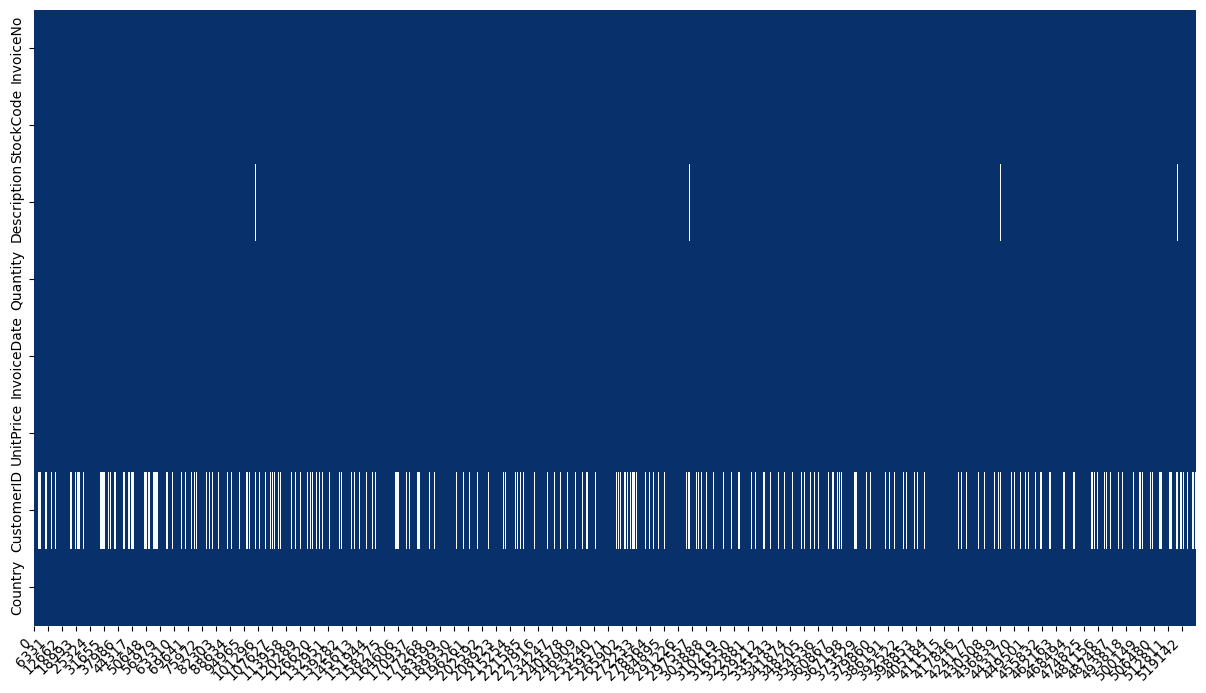

In [6]:
plot_missing_value(df, return_df = True)

Ne yazık ki CustomerID sütununda birçok eksik değer var. Lifetimes kütüphanesi RFM segmentasyonu için CustomerID'ye bağımlıdır. Bu nedenle eksik CustomerID değerlerini çıkarmak zorundayız. Lifetimes bunu otomatik olarak yapsa da, biz manuel olarak yapacağız.

### Sayısal Verilerin Özeti

In [7]:
df.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,525461.000000,525461,525461.000000,417534.000000
mean,10.337667,2010-06-28 11:37:36.845017856,4.688834,15360.645478
min,-9600.000000,2009-12-01 07:45:00,-53594.360000,12346.000000
25%,1.000000,2010-03-21 12:20:00,1.250000,13983.000000
50%,3.000000,2010-07-06 09:51:00,2.100000,15311.000000
75%,10.000000,2010-10-15 12:45:00,4.210000,16799.000000
max,19152.000000,2010-12-09 20:01:00,25111.090000,18287.000000
std,107.424110,NaN,146.126914,1680.811316


Yukarıdaki özet istatistiklere baktığımda, dikkatimi çeken ilk şey Quantity sütununun minimum ve maksimum değerleri. Değerler simetrik görünüyor, min -80995 ve max 80995. Bu durumun nedeni ne olabilir? Hangi olaylar bunu tetiklemiş olabilir?

Ayrıca UnitPrice sütununda negatif değerler de var. Bu borç mu?

Şimdi aykırı değerleri belirleyip, iki değişken arasındaki ilişkiyi anlamak için scatter plot oluşturalım.

### Outlier Belirleme

Aykırı değerleri IQR (Çeyrekler Arası Aralık) skoru kullanarak belirliyoruz. Formülü şöyle:
- IQR = Q3 - Q1
- alt sınır = Q1 - 1.5 * IQR
- üst sınır = Q3 + 1.5 * IQR 

#### Miktar (Quantity) Aykırı Değerleri

In [8]:
q1_quan = df['Quantity'].quantile(0.25)
q3_quan = df['Quantity'].quantile(0.75)
iqr_quan = q3_quan - q1_quan
lb_quan = float(q1_quan) - (1.5 * iqr_quan)
ub_quan = float(q3_quan) + (1.5 * iqr_quan)

print('Q1 = {}'.format(q1_quan))
print('Q3 = {}'.format(q3_quan))
print('IQR = Q3 - Q1 = {}'.format(iqr_quan))
print('Alt Sınır = Q1 - 1.5 * IQR = {}'.format(lb_quan))
print('Üst Sınır = Q3 + 1.5 * IQR = {}'.format(ub_quan))

Q1 = 1.0
Q3 = 10.0
IQR = Q3 - Q1 = 9.0
Alt Sınır = Q1 - 1.5 * IQR = -12.5
Üst Sınır = Q3 + 1.5 * IQR = 23.5


#### Birim Fiyat (UnitPrice) Aykırı Değerleri

In [9]:
q1_unit = df['UnitPrice'].quantile(0.25)
q3_unit = df['UnitPrice'].quantile(0.75)
iqr_unit = q3_unit - q1_unit 
lb_unit = float(q1_unit) - (1.5 * iqr_unit)
ub_unit = float(q3_unit) + (1.5 * iqr_unit)

print('Q1 = {}'.format(q1_unit))
print('Q3 = {}'.format(q3_unit))
print('IQR = Q3 - Q1 = {}'.format(iqr_unit))
print('Alt Sınır = Q1 - 1.5 * IQR = {}'.format(lb_unit))
print('Üst Sınır = Q3 + 1.5 * IQR = {}'.format(ub_unit))

Q1 = 1.25
Q3 = 4.21
IQR = Q3 - Q1 = 2.96
Alt Sınır = Q1 - 1.5 * IQR = -3.1899999999999995
Üst Sınır = Q3 + 1.5 * IQR = 8.649999999999999


### Miktar ve Birim Fiyat Arasındaki İlişki

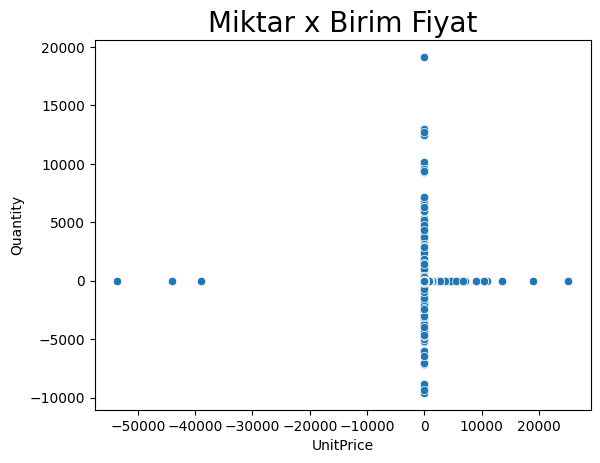

In [10]:
sns.scatterplot(x=df['UnitPrice'], y=df['Quantity'])
plt.title('Miktar x Birim Fiyat', fontsize = 20);

Grafiği çizdikten sonra, iki sütun arasındaki ilişki daha net görünüyor. 

Verimizde birkaç aşırı aykırı değer var: 

- En üstteki nokta grubu, düşük fiyatlı ürünlerden çok miktarda satın alan müşterileri temsil ediyor. En alttaki nokta grubu ise çok sayıda ürün iade eden müşteriler olabilir mi? Dikkatli bakıldığında, şekil en üstteki veri noktalarıyla simetrik görünüyor. Bunun anlamı ne olabilir? Analizime göre, bunlar muhtemelen toptancılar (reseller) olabilir çünkü miktarlarına bakıldığında, bir kişinin bu kadar çok ürün satın alması pek mümkün değil. Bu toptancılar muhtemelen düzenli olarak aynı ürünleri alıyor ve satılmayan ürünleri iade ediyorlar. Ancak bunun doğruluğunu kanıtlamak için, veri analistiyle konuşmak veya veri girişinde bir hata olup olmadığını kontrol etmek en iyisi olur. Ne yazık ki veri sağlayıcımız veriyi daha detaylı açıklayacak bir nomenklatür eklememiş.

- En soldaki nokta grubu için net bir açıklama yapamıyorum. Bunlar borçlu müşteriler olabilir mi? Yine de verimizin netliğini anlamak için veri analistiyle konuşmak en iyi yol olur.

- En sağdaki nokta grubu, yüksek fiyatlı ürünler satın alan müşterileri temsil ediyor. Miktarları aşırı olmadığı için muhtemelen bu ürünleri kendi kullanımları için alıyorlar. Bu oldukça normal görünüyor.

Genel olarak verimiz çeşitli müşteri tiplerini içeriyor: geniş fiyat aralığında düşük miktarda satın alanlar (muhtemelen kişisel kullanım) ve düşük fiyat aralığında yüksek miktarda satın alanlar (muhtemelen toptancılar).

Ama aykırı değerler olmadan scatter plot'un nasıl göründüğünü merak ediyorum, hadi kontrol edelim. 

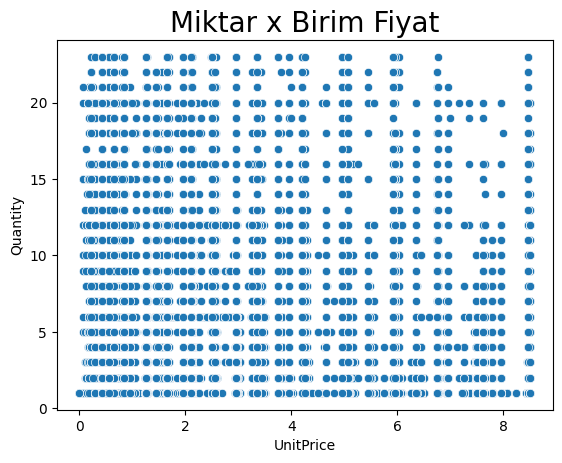

In [11]:
dx = df[df['Quantity']>0] #negatif değerleri kaldır
dy = df[df['UnitPrice']>0] #negatif değerleri kaldır

filtered_quantity = dx.query('(@q1_quan - 1.5 * @iqr_quan) <= Quantity <= (@q3_quan + 1.5 * @iqr_quan)')
filtered_unitprice = dy.query('(@q1_unit - 1.5 * @iqr_unit) <= UnitPrice <= (@q3_unit + 1.5 * @iqr_unit)')

sns.scatterplot(x=filtered_unitprice['UnitPrice'], y=filtered_quantity['Quantity'])
plt.title('Miktar x Birim Fiyat', fontsize = 20);

Genel olarak dağılım aynı görünüyor, ancak dikkatli bakıldığında sağ üst köşedeki noktaların yoğunluğunun azalmaya başladığı görülüyor, yani UnitPrice ne kadar yüksekse Quantity o kadar azalıyor.

Ancak yukarıdaki grafik görüntüsü çok net değil, daha kesin olmak için daha geniş bir kapsamla çizelim.

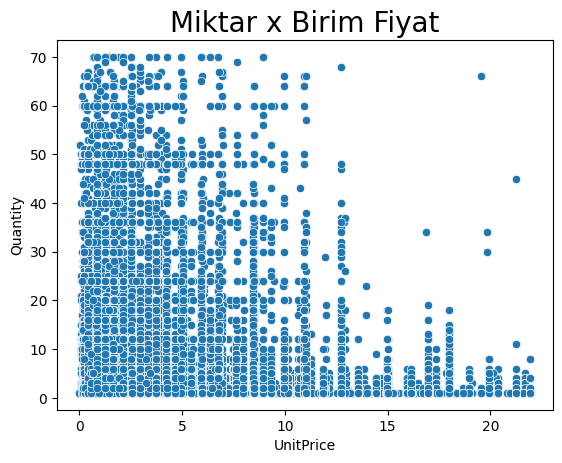

In [12]:
q1_quan_custom = df['Quantity'].quantile(0.5)
q3_quan_custom = df['Quantity'].quantile(0.95)
iqr_quan_custom = q3_quan_custom - q1_quan_custom

q1_unit_custom = df['UnitPrice'].quantile(0.5)
q3_unit_custom = df['UnitPrice'].quantile(0.95)
iqr_unit_custom = q3_unit_custom - q1_unit_custom

dx = df[df['Quantity']>0] #negatif değerleri kaldır
dy = df[df['UnitPrice']>0] #negatif değerleri kaldır

filtered_quantity = dx.query('(@q1_quan_custom - 1.5 * @iqr_quan_custom) <= Quantity <= (@q3_quan_custom + 1.5 * @iqr_quan_custom)')
filtered_unitprice = dy.query('(@q1_unit_custom - 1.5 * @iqr_unit_custom) <= UnitPrice <= (@q3_unit_custom + 1.5 * @iqr_unit_custom)')

sns.scatterplot(x=filtered_unitprice['UnitPrice'], y=filtered_quantity['Quantity'])
plt.title('Miktar x Birim Fiyat', fontsize = 20);

### Miktar ve Birim Fiyat Dağılımı

C:\Users\akif\AppData\Local\Temp\ipykernel_24064\417183854.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['Quantity'])


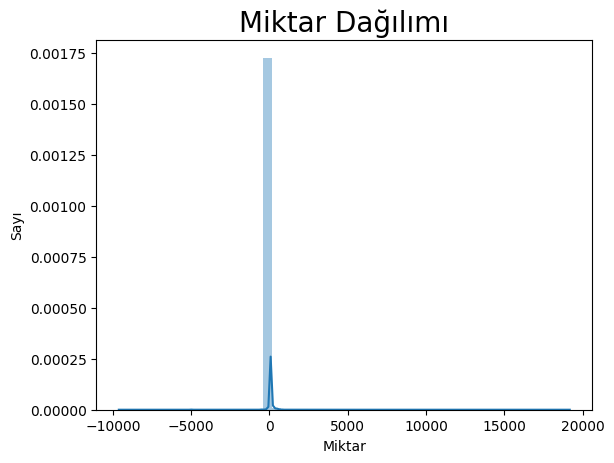

In [13]:
sns.distplot(df['Quantity'])
plt.title('Miktar Dağılımı', fontsize = 20)
plt.xlabel('Miktar')
plt.ylabel('Sayı');

C:\Users\akif\AppData\Local\Temp\ipykernel_24064\3961124232.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['UnitPrice'])


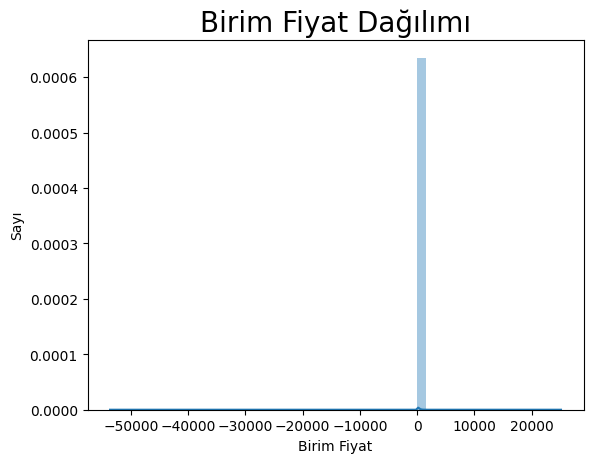

In [14]:
sns.distplot(df['UnitPrice'])
plt.title('Birim Fiyat Dağılımı', fontsize = 20)
plt.xlabel('Birim Fiyat')
plt.ylabel('Sayı');

### En Büyük 5 Ülke Grafiği

UK merkezli online perakende satın alma yapan en büyük 5 ülkenin grafiği

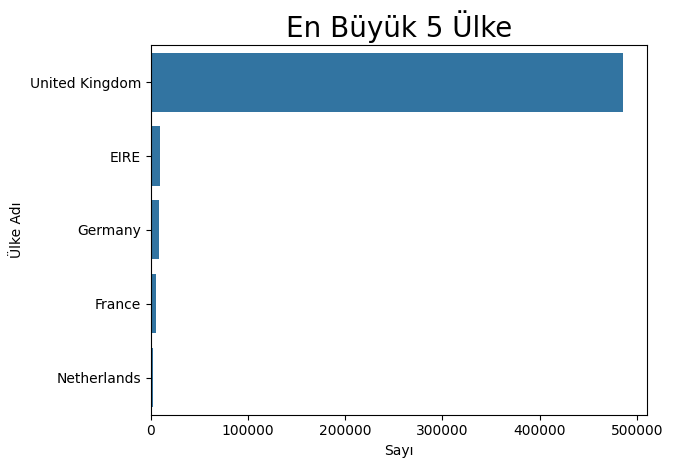

In [15]:
x = df['Country'].value_counts().head(5)
sns.barplot(x = x.values, y = x.index, )
plt.title('En Büyük 5 Ülke', fontsize = 20)
plt.xlabel('Sayı')
plt.ylabel('Ülke Adı');

Ülke sayısı ve gerçekleşen işlem sayısının detayları 

In [16]:
x = df['Country'].nunique()
print("Toplam {} ülke bulunmaktadır".format(x))

country = pd.DataFrame(df['Country'].value_counts()).reset_index()
country.columns = ['Ülke', 'İşlem Sayısı']
country

Toplam 40 ülke bulunmaktadır


,Ülke,İşlem Sayısı
0,United Kingdom,485852
1,EIRE,9670
2,Germany,8129
3,France,5772
4,Netherlands,2769
5,Spain,1278
6,Switzerland,1187
7,Portugal,1101
8,Belgium,1054
9,Channel Islands,906


EDA'yı tamamladıktan sonra şimdi veriyi RFM'ye dönüştürme zamanı. İlk olarak Lifetimes kütüphanesini, ikinci olarak K-means algoritmasını kullanacağım.

# Lifetimes Kütüphanesi Kullanarak Müşteri Segmentasyonu

Genel olarak, Lifetimes kullanarak müşteri segmentasyonu oluşturmanın adımları şunlar:

- 1. Veriyi hazırla
- 2. RFM oluştur

Sadece United Kingdom için segmentasyon yapacağız (çünkü verisi en fazla, hehe)

Modelleme yapmadan önce, veriyi Lifetimes'ın istediği dataframe formatına hazırlayalım.

## Veriyi Hazırla

Adım 1. UK dışındaki ülkeleri çıkar.

In [17]:
df = df[df['Country'] == 'United Kingdom']
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


Adım 2. InvoiceDate'i Python datetime nesnesine dönüştür

In [18]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


Adım 3. 'CustomerID' sütunundaki boş değerleri çıkar.

Aslında boş verileri dummy verilerle doldurabiliriz. Ancak bu sefer sadece çıkaracağız. Bu adım veri miktarını oldukça azaltacak.

In [19]:
df = df[~df['CustomerID'].isna()]
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


Adım 4. 'Quantity' ve 'UnitPrice' sütunlarındaki 0 ve negatif değerleri çıkar.

In [20]:
df = df[df['Quantity']>0]
df = df[df['UnitPrice']>0]
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


Adım 5. Revenue (Gelir) sütununu oluştur

Lifetimes kütüphanesine göre Revenue tanımı:
- Gelir = Birim Fiyat * Miktar

In [21]:
df['Revenue'] = df['Quantity'] * df['UnitPrice']
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0


Adım 6. Lifetimes'ın istediği dataframe formatını hazırla.

Yeni bir dataframe oluştur, tüm verileri InvoiceNo ve InvoiceDate'e göre topla.

In [22]:
orders = df.groupby(['InvoiceNo', 'InvoiceDate']).sum(numeric_only=True).reset_index()
orders.head()

,InvoiceNo,InvoiceDate,Quantity,UnitPrice,CustomerID,Revenue
0,489434,2009-12-01 07:45:00,166,32.65,104680.0,505.30
1,489435,2009-12-01 07:46:00,60,10.50,52340.0,145.80
2,489436,2009-12-01 09:06:00,193,70.88,248482.0,630.33
3,489437,2009-12-01 09:08:00,145,83.45,353326.0,310.75
4,489438,2009-12-01 09:24:00,826,44.05,307734.0,2286.24


Veri hazır, şimdi segmentasyon yapma zamanı

## Buat RFM Model

RFM modeli oluşturmanın adımları şunlar:

- Adım 1, RFM Değerlerini hesapla
- Adım 2, RFM Skorunu hesapla
- Adım 3, RFM skorunu genel olarak hesapla
- Adım 4, etiketleme

RFM Değeri ve RFM Skoru arasındaki farkı merak ediyorsanız: RFM Değeri, RFM'nin kendisinin değeridir, RFM Skoru ise RFM Değerine verilen skordur. Daha net anlamak için notebook'u takip edin. Devam edelim.

### Adım 1: RFM Değerlerini Hesapla

Bu adımda Lifetimes, daha önce hazırladığımız dataframe'e dayanarak otomatik olarak yeni bir dataframe oluşturacak.

Çıktıda frequency (sıklık), recency (yenilik), T ve monetary_value (parasal değer) sütunları bulunur. 

Şimdilik CustomerID ve T sütunlarını görmezden gelelim çünkü bunları kullanmayacağız. T sütununun ne olduğunu merak ediyorsanız:

- T, müşterinin ilk satın alma zamanından belirlenen zaman diliminin sonuna kadar olan süredir. Zaman birimi saat, gün, hafta vb. olabilir, bu politikanıza bağlıdır.

Recency ile farkı nedir? Recency açıklaması şöyle:

- Recency, müşterinin en son (recent) satın alma yaptığı zamandaki yaşıdır. Bu, ilk satın alma (first purchase) ile en son satın alma (latest purchase) arasındaki süreye eşittir. *Eğer müşteri sadece bir kez satın alma yaptıysa, recency değeri 0'dır.

In [23]:
rfm = summary_data_from_transaction_data(orders, 'CustomerID', 'InvoiceDate', monetary_value_col='Revenue').reset_index()
rfm

,CustomerID,frequency,recency,T,monetary_value
0,12346.0,4.0,39.0,360.0,28.375000
1,12748.0,32.0,360.0,360.0,104.766250
2,12823.0,9.0,285.0,314.0,480.611111
3,12835.0,2.0,126.0,315.0,10.050000
4,12843.0,4.0,272.0,316.0,58.202500
...,...,...,...,...,...
14045,3667440.0,0.0,0.0,62.0,0.000000
14046,3728704.0,0.0,0.0,63.0,0.000000
14047,4098360.0,0.0,0.0,184.0,0.000000
14048,4153799.0,0.0,0.0,32.0,0.000000


Değeri 0 olan çok sayıda sütun görüyoruz, ne oluyor?

Her şey recency'den başlıyor, recency tanımını hatırlıyor musunuz?

- Recency: Recency, müşterinin en son (recent) satın alma yaptığı zamandaki yaşıdır. Veya ilk satın alma (first purchase) ile en son satın alma (latest purchase) arasındaki süreye eşittir. *Eğer müşteri sadece bir kez satın alma yaptıysa, recency değeri 0'dır.

Yukarıdaki tanıma göre, çoğu müşteri tekrar satın alma yapmıyor, yani sadece bir kez satın alıyor. Bunun sonucunda frequency değeri de 0 oluyor, nasıl olabilir? Frequency tanımını okuyalım:

- Frequency: Müşterinin yaptığı tekrar satın alma sayısı. Veya toplam satın alma sayısı eksi bir.

Eğer müşterinin toplam satın alma sayısı sadece 1 ise, o zaman: 1-1= 0. Ve bu durumun monetary value'ya da etkisi var. Recency ve frequency zaten 0 ise, monetary value'ya ne hesaplanabilir?

Bu yüzden biraz daha ayarlama yapacağız. Şimdi frequency durumunu histogram ile kontrol edelim.

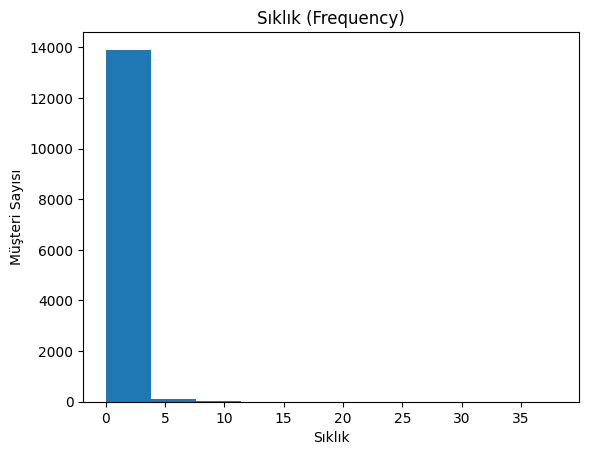

In [24]:
plt.hist(rfm['frequency'])
plt.title('Sıklık (Frequency)')
plt.ylabel('Müşteri Sayısı' )
plt.xlabel('Sıklık');

Görüldüğü gibi, tekrar işlem yapmayan müşterilerin sayısı çok fazla. Daha mantıklı segmentler oluşturmak için, tekrar satın alma yapmayan müşterilerin verilerini çıkaracağız.

In [25]:
rfm = rfm[rfm['frequency']>0]
rfm.head()

,CustomerID,frequency,recency,T,monetary_value
0,12346.0,4.0,39.0,360.0,28.375000
1,12748.0,32.0,360.0,360.0,104.766250
2,12823.0,9.0,285.0,314.0,480.611111
3,12835.0,2.0,126.0,315.0,10.050000
4,12843.0,4.0,272.0,316.0,58.202500


Yeni sütunun dağılımını görmek için tekrar histogram oluşturalım. Şimdi dağılım daha iyi görünüyor, ancak hala dengesizlik var.

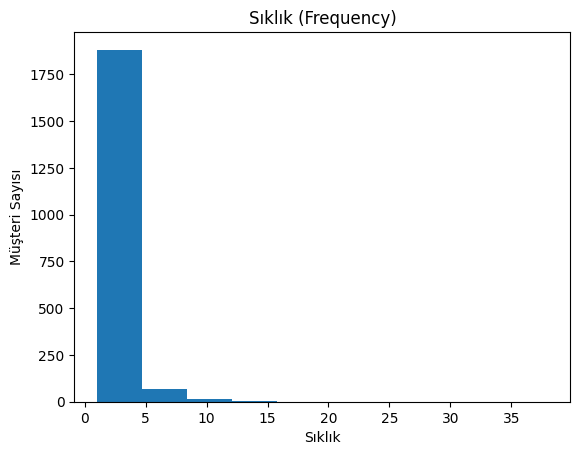

In [26]:
plt.hist(rfm['frequency'])
plt.title('Sıklık (Frequency)')
plt.ylabel('Müşteri Sayısı', )
plt.xlabel('Sıklık');

Şimdi sıra parasal değer (monetary_value) dağılımını histogram ile kontrol etmekte

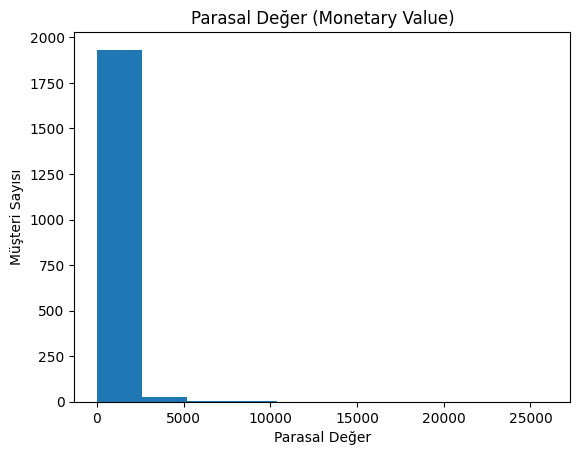

In [27]:
plt.hist(rfm['monetary_value'])
plt.title('Parasal Değer (Monetary Value)')
plt.ylabel('Müşteri Sayısı', )
plt.xlabel('Parasal Değer');

Tamam, tüm müşterilerin monetary value'su 0 ile 500 arasında görünüyor. Ancak monetary value'su 2000'in üzerinde, hatta 16000'e kadar çıkan müşteriler de var.

In [28]:
rfm = rfm[rfm['monetary_value']<2000]
rfm.head()

,CustomerID,frequency,recency,T,monetary_value
0,12346.0,4.0,39.0,360.0,28.375000
1,12748.0,32.0,360.0,360.0,104.766250
2,12823.0,9.0,285.0,314.0,480.611111
3,12835.0,2.0,126.0,315.0,10.050000
4,12843.0,4.0,272.0,316.0,58.202500


İşte aykırı değerler olmadan monetary value dağılımı. *Aslında aykırı değerleri daha fazla araştırmalı ve öylece çıkarmamalıyız, ancak bu sefer sadece çıkaracağız.

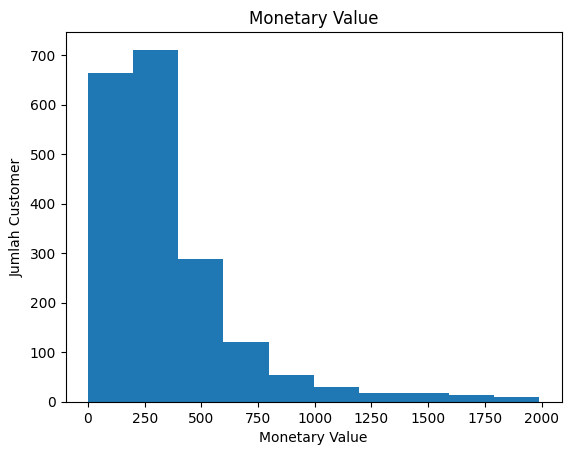

In [29]:
plt.hist(rfm['monetary_value'])
plt.title('Monetary Value')
plt.ylabel('Jumlah Customer', )
plt.xlabel('Monetary Value');

## Adım 2: Bireysel RFM Skorunu Hesapla

Bireysel RFM Skorunu hesaplamak birkaç yolla yapılabilir, müşteri tabanınıza uygun kendi iş hesaplama formülünüzü kullanabilirsiniz. Bu sefer istatistiksel Quartil yöntemini (Skoru dört parçaya bölme) kullanacağız.

In [30]:
quartiles = rfm.quantile(q=[0.25, 0.5, 0.75])
quartiles

,CustomerID,frequency,recency,T,monetary_value
0.25,69680.75,1.0,56.0,174.0,155.4375
0.50,174198.50,1.0,130.0,259.0,296.8275
0.75,312693.75,2.0,227.0,326.0,430.0950


In [31]:
def recency_score (data):
    if data <= 60:
        return 1
    elif data <= 128:
        return 2
    elif data <= 221:
        return 3
    else:
        return 4

def frequency_score (data):
    if data <= 1:
        return 1
    elif data <= 1:
        return 2
    elif data <= 2:
        return 3
    else:
        return 4

def monetary_value_score (data):
    if data <= 142.935:
        return 1
    elif data <= 292.555:
        return 2
    elif data <= 412.435:
        return 3
    else:
        return 4

rfm['R'] = rfm['recency'].apply(recency_score )
rfm['F'] = rfm['frequency'].apply(frequency_score)
rfm['M'] = rfm['monetary_value'].apply(monetary_value_score)
rfm.head()

,CustomerID,frequency,recency,T,monetary_value,R,F,M
0,12346.0,4.0,39.0,360.0,28.375000,1,4,1
1,12748.0,32.0,360.0,360.0,104.766250,4,4,1
2,12823.0,9.0,285.0,314.0,480.611111,4,4,4
3,12835.0,2.0,126.0,315.0,10.050000,2,3,1
4,12843.0,4.0,272.0,316.0,58.202500,4,4,1


Bireysel Skor elde edildikten sonra, şimdi RFM Skorunu genel olarak hesaplama zamanı

## Adım 3: RFM Skorunu Genel Olarak Hesapla

RFM Skorunu genel olarak hesaplamak için bireysel RFM skorlarının değerlerini toplamamız yeterli. 

In [32]:
rfm['RFM_score'] = rfm[['R', 'F', 'M']].sum(axis=1)
rfm.head()

,CustomerID,frequency,recency,T,monetary_value,R,F,M,RFM_score
0,12346.0,4.0,39.0,360.0,28.375000,1,4,1,6
1,12748.0,32.0,360.0,360.0,104.766250,4,4,1,9
2,12823.0,9.0,285.0,314.0,480.611111,4,4,4,12
3,12835.0,2.0,126.0,315.0,10.050000,2,3,1,6
4,12843.0,4.0,272.0,316.0,58.202500,4,4,1,9


## Adım 4: RFM Skoruna Etiket Ver

Skorları istediğiniz isim ve aralıkta etiketleyebilirsiniz, bu politikanıza bağlıdır. Bu sefer 5 bölüme ayıracağız, etiket sırası şöyle:
En düşük 'Bronze', ardından 'Silver', 'Gold', 'Platinum' ve en yüksek 'Diamond'

In [33]:
rfm['label'] = 'Bronze' 
rfm.loc[rfm['RFM_score'] > 4, 'label'] = 'Silver' 
rfm.loc[rfm['RFM_score'] > 6, 'label'] = 'Gold'
rfm.loc[rfm['RFM_score'] > 8, 'label'] = 'Platinum'
rfm.loc[rfm['RFM_score'] > 10, 'label'] = 'Diamond'

rfm.head()

,CustomerID,frequency,recency,T,monetary_value,R,F,M,RFM_score,label
0,12346.0,4.0,39.0,360.0,28.375000,1,4,1,6,Silver
1,12748.0,32.0,360.0,360.0,104.766250,4,4,1,9,Platinum
2,12823.0,9.0,285.0,314.0,480.611111,4,4,4,12,Diamond
3,12835.0,2.0,126.0,315.0,10.050000,2,3,1,6,Silver
4,12843.0,4.0,272.0,316.0,58.202500,4,4,1,9,Platinum


Ve işte oluşturduğumuz müşteri segmentasyonunun görünümü

  Silver  Gold  Bronze  Platinum  Diamond
     636   519     326       313      130


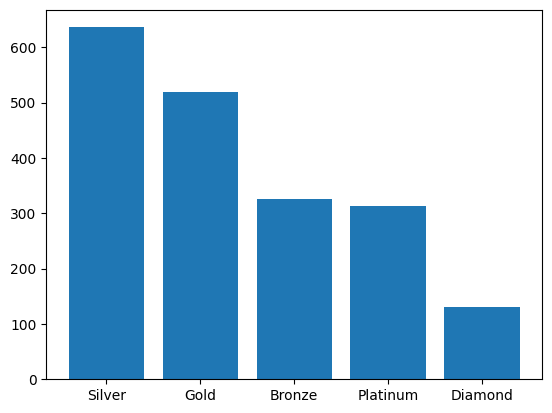

In [34]:
barplot = dict(rfm['label'].value_counts())
bar_names = list(barplot.keys())
bar_values = list(barplot.values())
plt.bar(bar_names,bar_values)
print(pd.DataFrame(barplot, index=[' ']))

Eğer daha önce pazarlama departmanı tüm müşterilere aynı stratejiyi uyguluyorsa, artık pazarlama ekibi RFM segmentasyonunu kullanarak daha spesifik hedefli stratejiler oluşturabilir.

Örneğin, müşterileri Diamond sınıfında tutmak için ne yapılmalı? Cevap özel indirimler sunmak, kişiselleştirilmiş ürünler hazırlamak vb. olabilir.

Bu aşamaya kadar segmentasyon sonuçlarını pazarlama departmanına strateji planlaması ve daha derinlemesine analiz için teslim edebiliriz.

# K-means Kullanarak Müşteri Segmentasyonu

Adımlar Lifetimes kütüphanesi kullanarak RFM oluştururken olduğu gibi: 

- A. Veriyi hazırla
- B. RFM oluştur

## A. Veriyi Hazırla

Import data

In [35]:
# Aynı dizindeki Excel dosyasını kullan
df2 = pd.read_excel("online_retail_II.xlsx")

# Sütun adlarını kontrol et ve standartlaştır
print("Orijinal sütun adları (df2):", df2.columns.tolist())

# Sütun adlarını standartlaştır - farklı varyasyonları kontrol et
column_mapping = {}

# UnitPrice için kontrol
if 'UnitPrice' not in df2.columns:
    if 'Price' in df2.columns:
        column_mapping['Price'] = 'UnitPrice'
    elif 'Unit Price' in df2.columns:
        column_mapping['Unit Price'] = 'UnitPrice'
    elif 'unitprice' in [col.lower() for col in df2.columns]:
        price_col = [col for col in df2.columns if col.lower() == 'unitprice'][0]
        column_mapping[price_col] = 'UnitPrice'

# CustomerID için kontrol
if 'CustomerID' not in df2.columns:
    if 'Customer ID' in df2.columns:
        column_mapping['Customer ID'] = 'CustomerID'
    elif 'CustomerId' in df2.columns:
        column_mapping['CustomerId'] = 'CustomerID'
    elif 'customerid' in [col.lower() for col in df2.columns]:
        cust_col = [col for col in df2.columns if col.lower() == 'customerid'][0]
        column_mapping[cust_col] = 'CustomerID'

# InvoiceNo için kontrol
if 'InvoiceNo' not in df2.columns:
    if 'Invoice' in df2.columns:
        column_mapping['Invoice'] = 'InvoiceNo'
    elif 'Invoice No' in df2.columns:
        column_mapping['Invoice No'] = 'InvoiceNo'
    elif 'invoiceno' in [col.lower() for col in df2.columns]:
        inv_col = [col for col in df2.columns if col.lower() == 'invoiceno'][0]
        column_mapping[inv_col] = 'InvoiceNo'

# Sütun adlarını değiştir
if column_mapping:
    df2.rename(columns=column_mapping, inplace=True)
    print("Sütun adları değiştirildi (df2):", column_mapping)

print("\nGüncel sütun adları (df2):", df2.columns.tolist())
df2.head()

Orijinal sütun adları (df2): ['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'Price', 'Customer ID', 'Country']
Sütun adları değiştirildi (df2): {'Price': 'UnitPrice', 'Customer ID': 'CustomerID', 'Invoice': 'InvoiceNo'}

Güncel sütun adları (df2): ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country']


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


InvoiceDate'i Python datetime nesnesine dönüştür

In [36]:
df2['InvoiceDate'] = pd.to_datetime(df2['InvoiceDate'])
df2.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


Biz de önceki gibi sadece United Kingdom'ı kullanacağız.

In [37]:
uk = df2[df2['Country'] == 'United Kingdom']
uk.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


## B. RFM Değerini Hesapla

K-means algoritması kullanarak RFM modeli oluşturmanın adımları:

- Adım 1, RFM Değerini hesapla, Küme sayısını belirle ve RFM Skorunu hesapla.
- Adım 2, RFM skorunu genel olarak hesapla
- Adım 3, Etiketleme

Daha önce RFM Değerini hesaplamak için Lifetimes kütüphanesini kullandıysak, bu sefer makine öğrenmesi algoritması olan K-means'i kullanacağız. K-means algoritması denetimsiz öğrenme (unsupervised learning) algoritmalarına dahildir, bu da etiketlenmemiş verileri işleyeceğimiz ve daha sonra çıktıyı kendi analizimize göre etiketleyeceğimiz anlamına gelir.

## Recency

### 1. Recency Değerini Hesapla

Recency değerini bulmak için, müşterinin son satın almasından bu yana kaç gün pasif kaldığını (satın alma yapmadığını) bilmemiz gerekir. Yöntem şöyle:

Mevcut her ID'yi al

In [38]:
main_df = pd.DataFrame(df2['CustomerID'].unique())
main_df.columns = ['CustomerID']
main_df.head()

,CustomerID
0,13085.0
1,13078.0
2,15362.0
3,18102.0
4,12682.0


Her ID için en son satın alma zamanını (latest purchase) al

In [39]:
latest_purchase = uk.groupby('CustomerID').InvoiceDate.max().reset_index()
latest_purchase.columns = ['CustomerID','LatestPurchaseDate']
latest_purchase.head()

,CustomerID,LatestPurchaseDate
0,12346.0,2010-10-04 16:33:00
1,12608.0,2010-10-31 10:49:00
2,12745.0,2010-08-10 10:14:00
3,12746.0,2010-06-30 08:19:00
4,12747.0,2010-12-05 15:38:00


Recency'yi hesapla, formülü:

Recency = gözlem zamanı - son satın alma günü

*gözlem zamanı olarak en güncel zamanı (the latest) kullanıyoruz.

In [40]:
latest_purchase['Recency'] = (latest_purchase['LatestPurchaseDate'].max() - latest_purchase['LatestPurchaseDate']).dt.days
latest_purchase.head()

,CustomerID,LatestPurchaseDate,Recency
0,12346.0,2010-10-04 16:33:00,66
1,12608.0,2010-10-31 10:49:00,39
2,12745.0,2010-08-10 10:14:00,121
3,12746.0,2010-06-30 08:19:00,162
4,12747.0,2010-12-05 15:38:00,4


CustomerID ve Recency sütunlarını göster

Yöntem size kalmış, bu sefer merge kullanacağım.

In [41]:
main_df = pd.merge(main_df, latest_purchase[['CustomerID','Recency']], on='CustomerID')
main_df.head()

,CustomerID,Recency
0,13085.0,55
1,13078.0,1
2,15362.0,83
3,18102.0,0
4,18087.0,14


Recency değerlerinin dağılımını çiz

C:\Users\akif\AppData\Local\Temp\ipykernel_24064\458720886.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(main_df['Recency'], kde=False, bins=50)


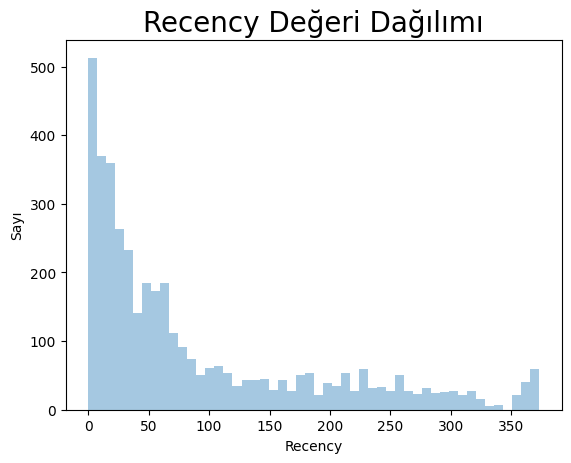

In [42]:
sns.distplot(main_df['Recency'], kde=False, bins=50)
plt.title('Recency Değeri Dağılımı', fontsize = 20)
plt.xlabel('Recency')
plt.ylabel('Sayı');

Recency dağılımı sağa çarpık

### 2. Küme Sayısını Belirle

Küme sayısını belirlemek için inertia (atalet) analizi kullanacağız

In [43]:
from sklearn.cluster import KMeans

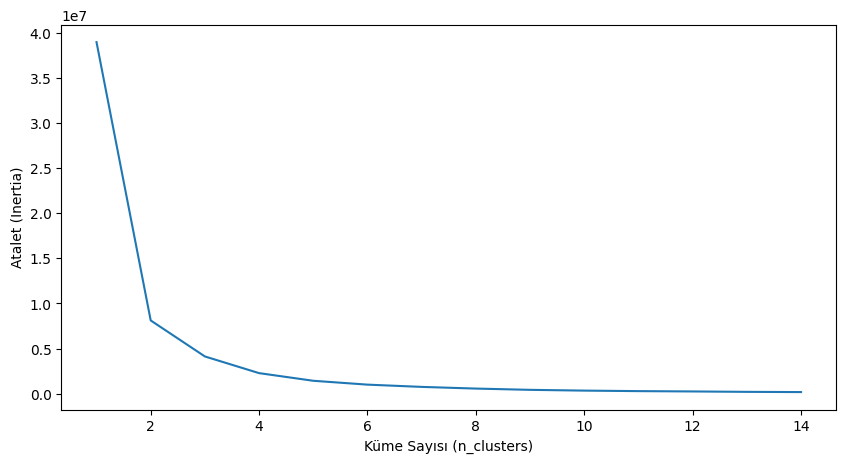

In [44]:
score = []
for k in range(1, 15):
    kmeans = KMeans(n_clusters=k)
    member = kmeans.fit_predict(np.array(main_df['Recency']).reshape(-1, 1))
    score.append(kmeans.inertia_)
    
plt.figure(figsize=(10, 5))
plt.plot(range(1, 15), score)
plt.ylabel("Atalet (Inertia)")
plt.xlabel("Küme Sayısı (n_clusters)");

Yukarıdaki grafiğe baktıktan sonra, 4 sınıf kullanmaya karar verdim çünkü 4, düşüşün en az keskin olduğu nokta.

Sonraki adım, Recency skorunu hesapla

### 3. Recency Skorunu Hesapla

In [45]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(main_df[['Recency']])
main_df['RecencyCluster'] = kmeans.predict(main_df[['Recency']])
main_df.head()

,CustomerID,Recency,RecencyCluster
0,13085.0,55,2
1,13078.0,1,0
2,15362.0,83,2
3,18102.0,0,0
4,18087.0,14,0


Oluşturduğumuz Recency'nin özet istatistiklerini (describe) kontrol et

Unutmayın, aşağıdaki kümeler henüz sıralanmamış, küme sıralamasını bilmiyoruz.

In [46]:
main_df.groupby('RecencyCluster')['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,2066.0,20.101646,14.996830,0.0,8.0,17.0,31.0,52.0
1,371.0,316.827493,37.482859,261.0,283.0,311.0,360.0,373.0
2,992.0,84.278226,25.134215,53.0,63.0,78.0,104.0,143.0
3,606.0,201.320132,33.378567,144.0,175.0,202.0,230.0,260.0


Değerlerin sıralama düzenini öğrenmek için aşağıdaki fonksiyonu kullanacağız

In [47]:
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

İşte sıralanmış kümeler:

In [48]:
main_df = order_cluster('RecencyCluster', 'Recency',main_df,False)
main_df.head()

,CustomerID,Recency,RecencyCluster
0,13085.0,55,2
1,13078.0,1,3
2,15362.0,83,2
3,18102.0,0,3
4,18087.0,14,3


In [49]:
main_df.groupby('RecencyCluster')['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,371.0,316.827493,37.482859,261.0,283.0,311.0,360.0,373.0
1,606.0,201.320132,33.378567,144.0,175.0,202.0,230.0,260.0
2,992.0,84.278226,25.134215,53.0,63.0,78.0,104.0,143.0
3,2066.0,20.101646,14.996830,0.0,8.0,17.0,31.0,52.0


Sonraki adımda aynı işlemi Frequency ve Monetary value için yapacağız

## Frequency

### 1. Frequency Değerini Hesapla

Frequency'yi hesaplamak için mevcut Frequency sütununu kullanabiliriz

CustomerID ve Frequency sütunlarını al

In [50]:
frequency = uk.groupby('CustomerID').InvoiceDate.count().reset_index()
frequency.columns = ['CustomerID','Frequency']
frequency.head()

,CustomerID,Frequency
0,12346.0,46
1,12608.0,16
2,12745.0,22
3,12746.0,20
4,12747.0,162


Daha önce oluşturduğumuz recency dataframe'i ile birleştir

In [51]:
main_df = pd.merge(main_df, frequency, on='CustomerID')
main_df.head()

,CustomerID,Recency,RecencyCluster,Frequency
0,13085.0,55,2,63
1,13078.0,1,3,475
2,15362.0,83,2,40
3,18102.0,0,3,635
4,18087.0,14,3,88


Frequency özet istatistiklerini kontrol et

In [52]:
main_df.Frequency.describe()

count    4035.000000
mean       94.032962
std       185.614002
min         1.000000
25%        18.000000
50%        43.000000
75%       103.000000
max      5114.000000
Name: Frequency, dtype: float64

Frequency Değeri Dağılımını Çiz

C:\Users\akif\AppData\Local\Temp\ipykernel_24064\1689607633.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(main_df['Frequency'], kde=False, bins=50)


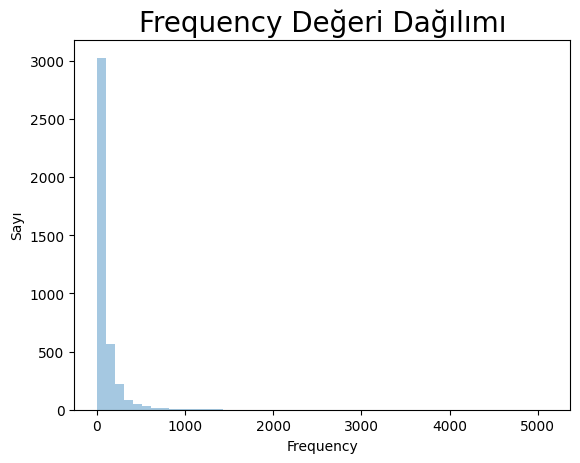

In [53]:
sns.distplot(main_df['Frequency'], kde=False, bins=50)
plt.title('Frequency Değeri Dağılımı', fontsize = 20)
plt.xlabel('Frequency')
plt.ylabel('Sayı');

### 2. Küme Sayısını Belirle

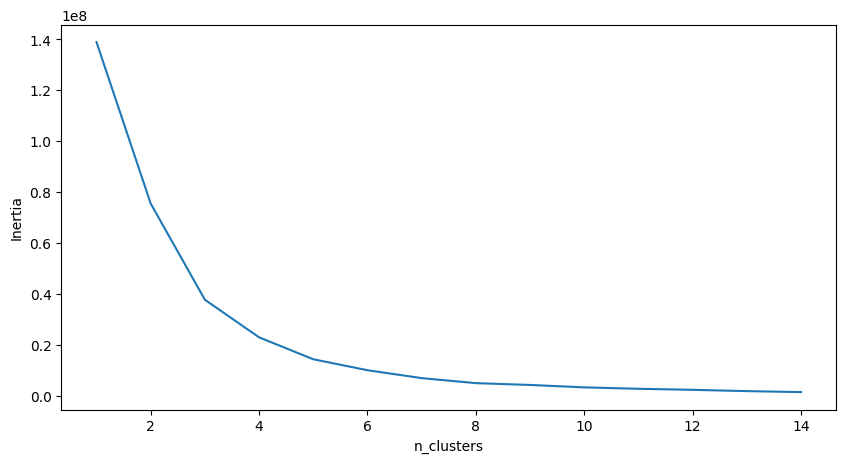

In [54]:
score = []
for k in range(1, 15):
    kmeans = KMeans(n_clusters=k)
    member = kmeans.fit_predict(np.array(main_df['Frequency']).reshape(-1, 1))
    score.append(kmeans.inertia_)
    
plt.figure(figsize=(10, 5))
plt.plot(range(1, 15), score)
plt.ylabel("Inertia")
plt.xlabel("n_clusters");

Recency gibi, 4 küme kullanacağız

### 3. Frequency Skorunu Hesapla

In [55]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(main_df[['Frequency']])
main_df['FrequencyCluster'] = kmeans.predict(main_df[['Frequency']])
main_df.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster
0,13085.0,55,2,63,0
1,13078.0,1,3,475,1
2,15362.0,83,2,40,0
3,18102.0,0,3,635,1
4,18087.0,14,3,88,0


Sırala

İşte oluşturduğumuz Frequency kümelerinin sonuçları

In [56]:
main_df = order_cluster('FrequencyCluster', 'Frequency',main_df,True)
main_df.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster
0,13085.0,55,2,63,0
1,13078.0,1,3,475,1
2,15362.0,83,2,40,0
3,18102.0,0,3,635,1
4,18087.0,14,3,88,0


Frequency kümesinin detaylı durumu

In [57]:
main_df.groupby('FrequencyCluster')['Frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,3562.0,51.552779,46.914522,1.0,16.00,36.0,75.00,198.0
1,449.0,344.011136,146.500876,199.0,236.00,290.0,413.00,871.0
2,22.0,1467.727273,518.091294,937.0,1115.75,1267.5,1672.50,2665.0
3,2.0,4520.500000,839.335749,3927.0,4223.75,4520.5,4817.25,5114.0


## Monetary Value (Revenue)

### 1. Monetary Value (Parasal Değer) Hesapla

Monetary Value'yu hesaplamak için UnitPrice ile Quantity'yi çarpmanız yeterli

In [58]:
uk['Revenue'] = uk['UnitPrice'] * uk['Quantity']
revenue = uk.groupby('CustomerID').Revenue.sum().reset_index()
revenue.head()

,CustomerID,Revenue
0,12346.0,-64.68
1,12608.0,415.79
2,12745.0,723.85
3,12746.0,230.85
4,12747.0,4968.58


dataframe'leri birleştir

In [59]:
main_df = pd.merge(main_df, revenue, on='CustomerID')
main_df.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue
0,13085.0,55,2,63,0,1187.08
1,13078.0,1,3,475,1,16451.55
2,15362.0,83,2,40,0,613.08
3,18102.0,0,3,635,1,341776.73
4,18087.0,14,3,88,0,10641.50


In [60]:
main_df['Revenue'].describe()

count      4035.000000
mean       1744.374135
std        7103.868943
min      -25111.090000
25%         277.875000
50%         636.250000
75%        1573.555000
max      341776.730000
Name: Revenue, dtype: float64

C:\Users\akif\AppData\Local\Temp\ipykernel_24064\780104244.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(main_df['Revenue'], kde=False, bins=50)


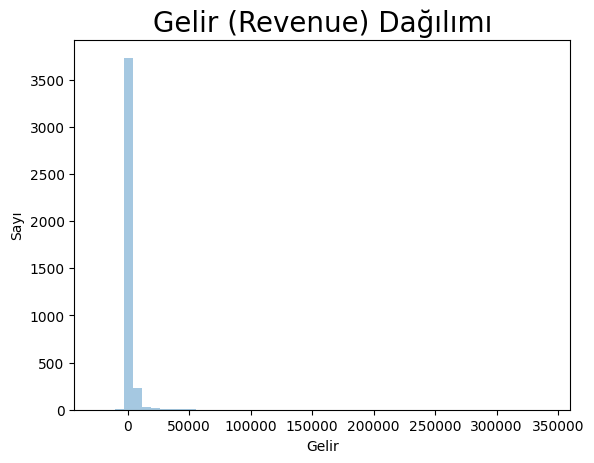

In [61]:
sns.distplot(main_df['Revenue'], kde=False, bins=50)
plt.title('Gelir (Revenue) Dağılımı', fontsize = 20)
plt.xlabel('Gelir')
plt.ylabel('Sayı');

### 2. Küme Sayısını Belirle

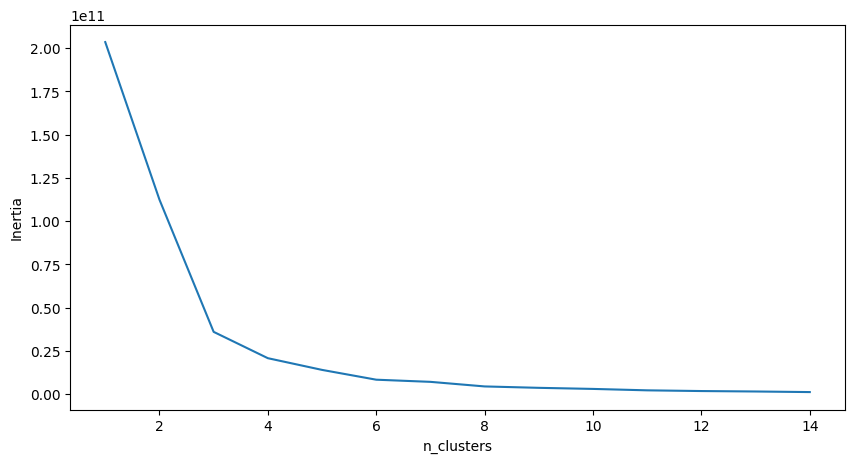

In [62]:
score = []
for k in range(1, 15):
    kmeans = KMeans(n_clusters=k)
    member = kmeans.fit_predict(np.array(main_df['Revenue']).reshape(-1, 1))
    score.append(kmeans.inertia_)
    
plt.figure(figsize=(10, 5))
plt.plot(range(1, 15), score)
plt.ylabel("Inertia")
plt.xlabel("n_clusters");

### 3. Monetary Skorunu Hesapla

In [63]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(main_df[['Revenue']])
main_df['RevenueCluster'] = kmeans.predict(main_df[['Revenue']])
main_df.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster
0,13085.0,55,2,63,0,1187.08,1
1,13078.0,1,3,475,1,16451.55,0
2,15362.0,83,2,40,0,613.08,1
3,18102.0,0,3,635,1,341776.73,2
4,18087.0,14,3,88,0,10641.50,0


Sırala

In [64]:
main_df = order_cluster('RevenueCluster', 'Revenue',main_df,True)
main_df.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster
0,13085.0,55,2,63,0,1187.08,0
1,13078.0,1,3,475,1,16451.55,1
2,15362.0,83,2,40,0,613.08,0
3,18102.0,0,3,635,1,341776.73,3
4,18087.0,14,3,88,0,10641.50,1


İşte Monetary Value kümesinin görünümü

In [65]:
main_df.groupby('RevenueCluster')['Revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
RevenueCluster,,,,,,,,
0,3870.0,1033.478021,1292.571248,-25111.09,263.6775,602.765,1392.250,6460.32
1,148.0,12016.828736,6140.121106,6533.07,7503.7000,9525.270,14491.285,32445.66
2,16.0,57420.144375,24190.298238,37222.05,40619.5625,48373.380,60773.775,128172.42
3,1.0,341776.730000,NaN,341776.73,341776.7300,341776.730,341776.730,341776.73


## RFM Skorunu Genel Olarak Hesapla 

Skor hesaplama kuralları:

- Recency: Recency değeri ne kadar düşükse, skor o kadar yüksektir.
- Frequency: Frequency değeri ne kadar yüksekse, skor o kadar yüksektir.
- Monetary: Monetary değeri ne kadar yüksekse, skor o kadar yüksektir.

In [66]:
main_df['RFM_score'] = main_df['RecencyCluster'] + main_df['FrequencyCluster'] + main_df['RevenueCluster']
main_df.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,RFM_score
0,13085.0,55,2,63,0,1187.08,0,2
1,13078.0,1,3,475,1,16451.55,1,5
2,15362.0,83,2,40,0,613.08,0,2
3,18102.0,0,3,635,1,341776.73,3,7
4,18087.0,14,3,88,0,10641.50,1,4


In [67]:
main_df['RFM_score'].unique()

array([2, 5, 7, 4, 3, 0, 6, 1])

Sahip olduğumuz en yüksek skor 8'dir (toplam 9'dan, R=3, F=3, M=3)

In [68]:
main_df.groupby('RFM_score')[['Recency','Frequency','Revenue']].mean()
main_df.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,RFM_score
0,13085.0,55,2,63,0,1187.08,0,2
1,13078.0,1,3,475,1,16451.55,1,5
2,15362.0,83,2,40,0,613.08,0,2
3,18102.0,0,3,635,1,341776.73,3,7
4,18087.0,14,3,88,0,10641.50,1,4


Gruplama (Binning).

2'nin altı düşük değer
2-4 arası orta değer
4'ün üstü yüksek değer

In [69]:
main_df['label'] = 'Bronze' 
main_df.loc[main_df['RFM_score'] > 1, 'label'] = 'Silver' 
main_df.loc[main_df['RFM_score'] > 2, 'label'] = 'Gold'
main_df.loc[main_df['RFM_score'] > 3, 'label'] = 'Platinum'
main_df.loc[main_df['RFM_score'] > 5, 'label'] = 'Diamond'

main_df.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,RFM_score,label
0,13085.0,55,2,63,0,1187.08,0,2,Silver
1,13078.0,1,3,475,1,16451.55,1,5,Platinum
2,15362.0,83,2,40,0,613.08,0,2,Silver
3,18102.0,0,3,635,1,341776.73,3,7,Diamond
4,18087.0,14,3,88,0,10641.50,1,4,Platinum


İşte oluşturduğumuz etiketlerin çubuk grafiği

  Gold  Bronze  Silver  Platinum  Diamond
  1672     965     944       429       25


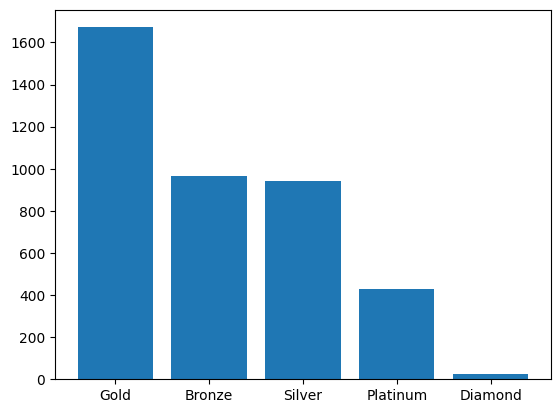

In [70]:
barplot = dict(main_df['label'].value_counts())
bar_names = list(barplot.keys())
bar_values = list(barplot.values())
plt.bar(bar_names,bar_values)
print(pd.DataFrame(barplot, index=[' ']))

## Kesimpulan 

RFM segmentasyonu müşteri segmentasyonu oluşturmak için kolay bir yöntemdir. Çıktısı sezgiseldir, bu yüzden pazarlama ekibi tarafından anlaşılması ve yorumlanması kolaydır. Ancak kolaylığının arkasında, RFM yönteminin bazı eksiklikleri vardır:

- RFM segmentasyonu hesaplaması sadece üç faktörü dikkate alır (Recency, Frequency ve Monetary Value) ve diğer eşit veya daha önemli olabilecek faktörleri göz ardı eder (demografik detaylar, ürün türleri vb.)

- RFM müşteri segmentasyonu tarihsel bir yöntemdir, yani segmentasyon değerlendirmesi sadece geçmiş verilere dayanır ve müşterinin gelecekteki durumunu iyi bir şekilde yansıtmayabilir.

Bu yüzden, kararları sadece RFM segmentasyonuna göre almayın, karar vermede bakış açımızı genişletmek için diğer model analizlerini de dikkate alın.

Peki Lifetimes Kütüphanesi ve K-means arasında hangisi daha iyi? Eğer veri setinizde eksik değerler yoksa, ben kişisel olarak sadece kütüphaneyi kullanmanızı öneririm çünkü daha hızlı, kolay ve pratiktir. Eğer veri setinizde eksik değerler varsa, eksik değerleri doldurmak için impute yapabilirsiniz, ancak bu elbette kütüphaneden beklediğimiz pratikliği azaltacaktır.

Belki bu kadar, eğer sorularınız veya önerileriniz varsa, yorum bölümüne yazabilir veya Instagram'dan bana ulaşabilirsiniz: al.fath.terry

Ve... faydalı bulduysanız lütfen beğenin.

Diğer notebook'larımı da kontrol edebilirsiniz...

Teşekkürler :)